# Import libraries and dataset

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
train = pd.read_csv('train.csv', index_col=0)

#### Labels
train.csv: A full training dataset with the following attributes:

- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable(1: unreliable, 0: reliable)

test.csv: A testing training dataset with all the same attributes at train.csv without the label.

In [3]:
train.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


No need to randomize order as dataset appears to be interspersed with 1s and 0s

In [4]:
train.shape

(20800, 4)

In [5]:
train.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

Can fill null values with empty string since we have a big dataset

In [6]:
train = train.fillna('')

In [7]:
train['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

Distribution of unreliable (1) and reliable (0) observations are about even

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20800 non-null  object
 1   author  20800 non-null  object
 2   text    20800 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 812.5+ KB


'label' column is already in numerical format, no data transformation required.

# Pre-processing

In [9]:
train['content'] = train['title'] + train['author']
# Due to the length of each row in the 'text' column, we train the model using only the 'title' and 'author' columns

In [10]:
port_stem = PorterStemmer()

def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content ) # replace non-letters with empty string
    stemmed_content = stemmed_content.lower() # make all words lower case
    stemmed_content = stemmed_content.split() # split sentences into list of words
    
    # Remove stopwords, then remove prefixes & suffixes of remaining words to reduce them to their root words
    # Stopwords are common words that carry little information 
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')] 
    
    
    stemmed_content = ' '.join(stemmed_content) # join all the words together
    return stemmed_content

In [11]:
train['content'] = train['content'].apply(stemming)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [13]:
# For X, drop the target variable and retain the rest of the features
# Set y as target variable

X = train['content']
y = train['label']

In [14]:
# Convert text into numerical data for machine learning
vectorizer = TfidfVectorizer()
# Term Frequency (TF): number of times word appears in document
# Inverse Document Frequency (IDF): measure of word's significance, based on its frequency across documents

vectorizer.fit(X) # compute IDF values of words from training data 
X = vectorizer.transform(X) # compute TF-IDF values using IDF values from previous step

In [15]:
# Split training and testing data in 2:8 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Data Modeling

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV

### Logistic Regression 

In [17]:
# Fit model to training data

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

lr = LogisticRegression()

# Loop through predefined hyperparameters to select best ones
lr = GridSearchCV(estimator = lr,
                 param_grid=param_grid,
                 n_jobs = -1)

# Fit training data to logistic regression
lr.fit(X_train, y_train);

#### Training Data

In [18]:
# training data accuracy
y_pred = lr.predict(X_train)
y_pred_acc = accuracy_score(y_pred, y_train)
print ('Training Accuracy: ', y_pred_acc)

Training Accuracy:  1.0


In [19]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8310
           1       1.00      1.00      1.00      8330

    accuracy                           1.00     16640
   macro avg       1.00      1.00      1.00     16640
weighted avg       1.00      1.00      1.00     16640



[[8310    0]
 [   0 8330]]


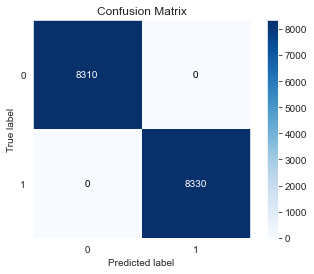

In [20]:
print(confusion_matrix(y_train, y_pred))
skplt.metrics.plot_confusion_matrix(y_train, y_pred);

#### Test Data

In [21]:
# Use model to predict test data
y_pred = lr.predict(X_test)
y_pred_acc = accuracy_score(y_pred, y_test)
print ('Test Accuracy: ', y_pred_acc)

Test Accuracy:  0.9865384615384616


In [22]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2071
           1       0.99      0.99      0.99      2089

    accuracy                           0.99      4160
   macro avg       0.99      0.99      0.99      4160
weighted avg       0.99      0.99      0.99      4160



[[2046   31]
 [  25 2058]]


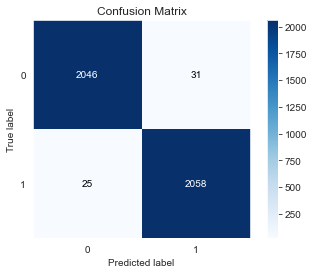

In [23]:
print(confusion_matrix(y_test, y_pred))
skplt.metrics.plot_confusion_matrix(y_test, y_pred);